# E2a: Küchentischversuch zum Laval-Rotor

Name: Gruber Thomas 
Datum:  9.1.2024

## Forschungsfrage

Formulieren Sie eine oder mehrere Forschungsfragen zu der Lerneinheit: Kann man mit den vorhandenen einfachen Mitteln ein sinnvolles Messergebnis erzielen?

# Erster Versuch
Hier werden Sie den ersten Gegenstand auswerten. Die Auswertung des zweiten Gegenstands kann das analog erfolgen, die entsprechenden jupyter-notebook-Zellen sind weiter unten vorbereitet.

##  Versuchsaufbau und -durchführung

Beachten Sie, dass Sie den Code zum Auslesen des Beschleunigungssensor ausschließlich mit dem Raspberry Pi ausführen können.


- Bild von Aufbau des Haushaltsgegenstands:

<img src="Lautsprecher.jpeg" width="500">

- Beschreibung des Aufbaus: Beschleunigungssensor welcher mit dem Pi verbunden ist, wurde am Mixer befestigt. 
- Vorgangsbeschreibung: Der Mixer wurde in Betrieb genommen. Währenddessen wurden Sensordaten gebildet.

## Versuchsauswertung

Die Vermessung des Haushaltsgegenstands wird in diesem Notebook ausgewertet, dazu werden die drei Funktionen ```get_vec_accel()```, ```interpolation()``` und ```my_fft()``` in ```functions/m_postprocessing.py``` verwendet. Die Ein- und Ausgangsgrößen der Funktionen sind in ```functions/m_postprocessing.py``` definiert, bitte berücksichtigen Sie die vordefinierten Datentypen.


Alle Codeblöcke, in denen Sie Änderungen vornehmen müssen, sind nachfolgend markiert.

In [21]:
import h5py
import numpy as np
import json
import os

%matplotlib inline
import matplotlib.pyplot as plt

from functions.m_operate import evaluate_metadata

from functions.m_postprocessing import get_vec_accel
from functions.m_postprocessing import interpolation
from functions.m_postprocessing import my_fft

path = os.path.join("supplementary_code", "FST.mplstyle")
plt.style.use(path)

#### 1a. Einlesen der Mess- und Metadaten

In [22]:
"""Parameter definition"""
# -------------------------------------------------------------------------------------------#1-start
# TODO: Adjust the parameters to your needs. Please use relative paths!
path_measurement_folder = "/home/pi/lavalrotor_home_experiment/measurement_data/data_20240109_173026_thomasgruber_Mixer" # replace None by the relative path to the first object's folder
h5_file_name =  "data_20240109_173026_thomasgruber_Mixer.h5" # replace None by the filename of the hdf5-file
file_path= "/home/pi/lavalrotor_home_experiment/measurement_data/data_20240109_173026_thomasgruber_Mixer/data_20240109_173026_thomasgruber_Mixer.h5" 
# ---------------------------------------------------------------------------------------------#1-end

In [23]:
"""Prepare Metadata"""
(setup_json_dict, sensor_settings_dict, probe_name) = evaluate_metadata(
    path_measurement_folder
)

print(json.dumps(setup_json_dict, indent=2, default=str))
print(json.dumps(sensor_settings_dict, indent=2, default=str))
print("Probe: {}".format(probe_name))


{
  "1ee846ef-4df0-632a-bfdb-ef2ea3181b39": {
    "type": "general",
    "name": "general_info",
    "comment": "",
    "path": "/home/pi/lavalrotor_home_experiment/measurement_data/data_20240109_173026_thomasgruber_Mixer/1ee846ef-4df0-632a-bfdb-ef2ea3181b39.json"
  },
  "1ee846f1-b588-6d3c-9659-7c3266d530e8": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "/home/pi/lavalrotor_home_experiment/measurement_data/data_20240109_173026_thomasgruber_Mixer/1ee846f1-b588-6d3c-9659-7c3266d530e8.json"
  },
  "1ee847be-fddd-6ee4-892a-68c4555b0981": {
    "type": "sensor",
    "name": "accelerometer",
    "range": {
      "min": -2,
      "max": 2,
      "units": "standard_gravity"
    },
    "frequency": {
      "value": 800,
      "units": "Hertz"
    },
    "comment": "",
    "path": "/home/pi/lavalrotor_home_experiment/measurement_data/data_20240109_173026_thomasgruber_Mixer/1ee847be-fddd-6ee4-892a-68c4555b0981.json"
  },
  "1eeab0a9-708a-6226-8ad7-897842

#### 1b. Auslesen der Beschleunigungen und der Zeit in numpy-arrays

In [24]:
with h5py.File(file_path, "r") as h5_file:
    # Access the datasets under the sensor UUID group
    dataset_x = h5_file[f"RawData/1ee847be-fddd-6ee4-892a-68c4555b0981/acceleration_x"]
    dataset_y = h5_file[f"RawData/1ee847be-fddd-6ee4-892a-68c4555b0981/acceleration_y"]
    dataset_z = h5_file[f"RawData/1ee847be-fddd-6ee4-892a-68c4555b0981/acceleration_z"]
    timestamp_dataset = h5_file[f"RawData/1ee847be-fddd-6ee4-892a-68c4555b0981/timestamp"]


    # Read data into NumPy arrays
    time = np.array(timestamp_dataset)
    acceleration_x = np.array(dataset_x)
    acceleration_y = np.array(dataset_y)
    acceleration_z = np.array(dataset_z)
    
    print(acceleration_x)
    print(acceleration_y)
    print(acceleration_z)
    print(time)


[0.2745862 0.2745862 0.2745862 ... 0.3138128 0.3530394 0.3530394]
[10.591182  10.591182  10.591182  ... 10.7088618 10.4735022 10.4735022]
[1.2552512 1.2552512 1.2552512 ... 2.1966896 1.7259704 1.7259704]
[1.70481783e+09 1.70481783e+09 1.70481783e+09 ... 1.70481785e+09
 1.70481785e+09 1.70481785e+09]


#### 2. Betrag der Beschleunigung berechnen

Die Messdaten des Beschleunigungssensors sind vektorielle Werte (```acc_x, acc_y, acc_z```). Berechnen Sie für jeden Zeitpunkt in ```vec_time``` den Betrag des Beschleunigungsvektors. Verwenden Sie dazu die Funktion ```get_vec_accel()```. In den folgenden Aufgaben wird der Betrag der Beschleunigung weiterverwendet.

In [25]:
absolute_value_acceleration= get_vec_accel(acceleration_x, acceleration_y, acceleration_z)

print(absolute_value_acceleration)



[10.66884199 10.66884199 10.66884199 ... 10.93634513 10.62063364
 10.62063364]


#### 3. Darstellung der Messdaten
Stellen Sie den Betrag der Beschleunigung über die Zeit und die zeitlichen Abstände zwischen den Messpunkten über die Zeit graphisch dar. Achten Sie dabei auf eine sinnvolle Achsenbeschriftung. 

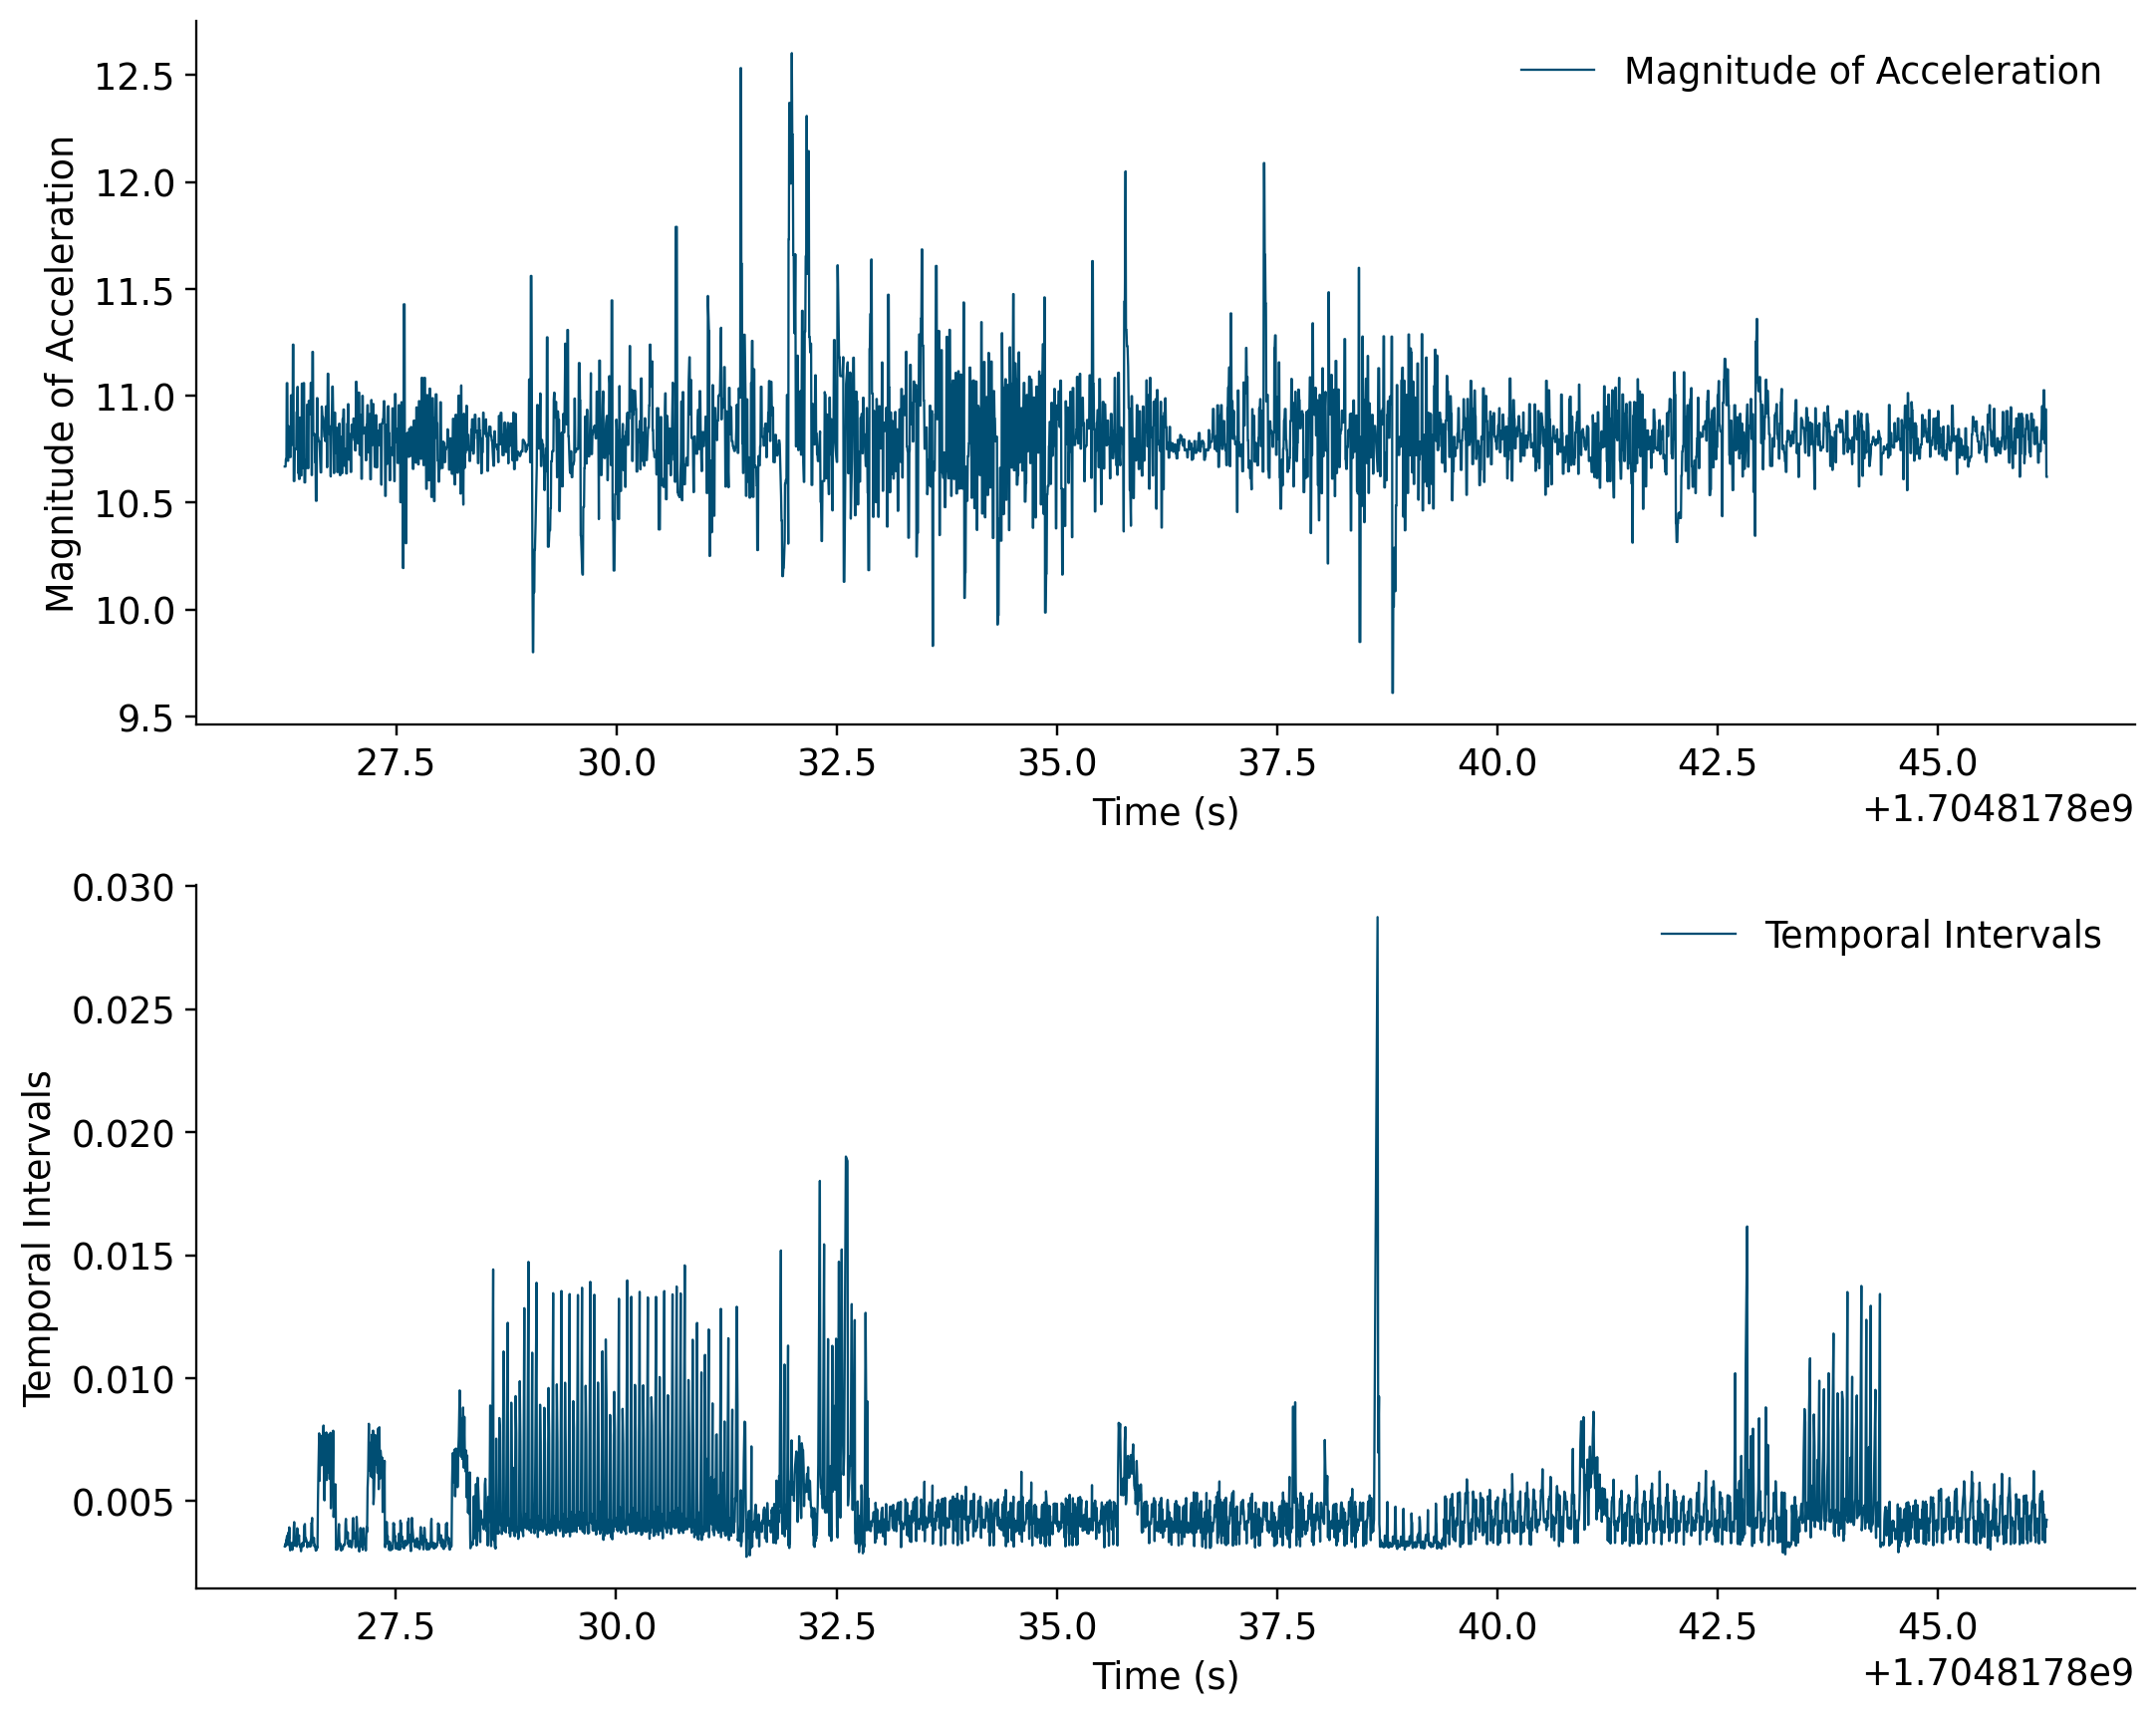

In [26]:
zeitintervall = np.diff(time)

# Plotte die Ergebnisse
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plotte die Betragsgröße der Beschleunigung über die Zeit
ax1.plot(time, absolute_value_acceleration, label='Magnitude of Acceleration')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Magnitude of Acceleration')
ax1.legend()

# Plotte zeitliche Intervalle über die Zeit
ax2.plot(time[1:], zeitintervall, label='Temporal Intervals')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Temporal Intervals')
ax2.legend()
plt.tight_layout()
plt.show()

#### 4. Interpolation der Messwerte

Da es sich beim Pi nicht um ein Echtzeit-Messsystem handelt, variieren die Zeitabstände zwischen den Messwerten. Da für die FFT äquidistante Messwerte benötigt werden, ist eine Interpolation der Daten erforderlich.

In [27]:
# -------------------------------------------------------------------------------------------#4-start
# TODO: Write the function interpolation() (in m_postprocessing) to linearly interpolate the
# acceleration.
interp_time, interp_data = interpolation(time, absolute_value_acceleration)

 

# Drucken Sie die Ergebnisse oder visualisieren Sie sie

print("Interpolierte Zeit:", interp_time)

print("Interpolierte Daten:", interp_data)



Interpolierte Zeit: [1.70481783e+09 1.70481783e+09 1.70481783e+09 ... 1.70481785e+09
 1.70481785e+09 1.70481785e+09]
Interpolierte Daten: [10.66884199 10.66884199 10.66884199 ... 10.93634513 10.6337166
 10.62063364]


#### 5 & 6. FFT durchführen und graphisch darstellen

Transformieren Sie die interpolierten Beträge der Beschleunigung mit der Funktion ```my_fft()``` in den Frequenzraum. Eine Skalierung der Amplitude der FFT ist nicht notwendig.
Stellen Sie die Amplitude des Signals als Funktion der Frequenz graphisch dar.

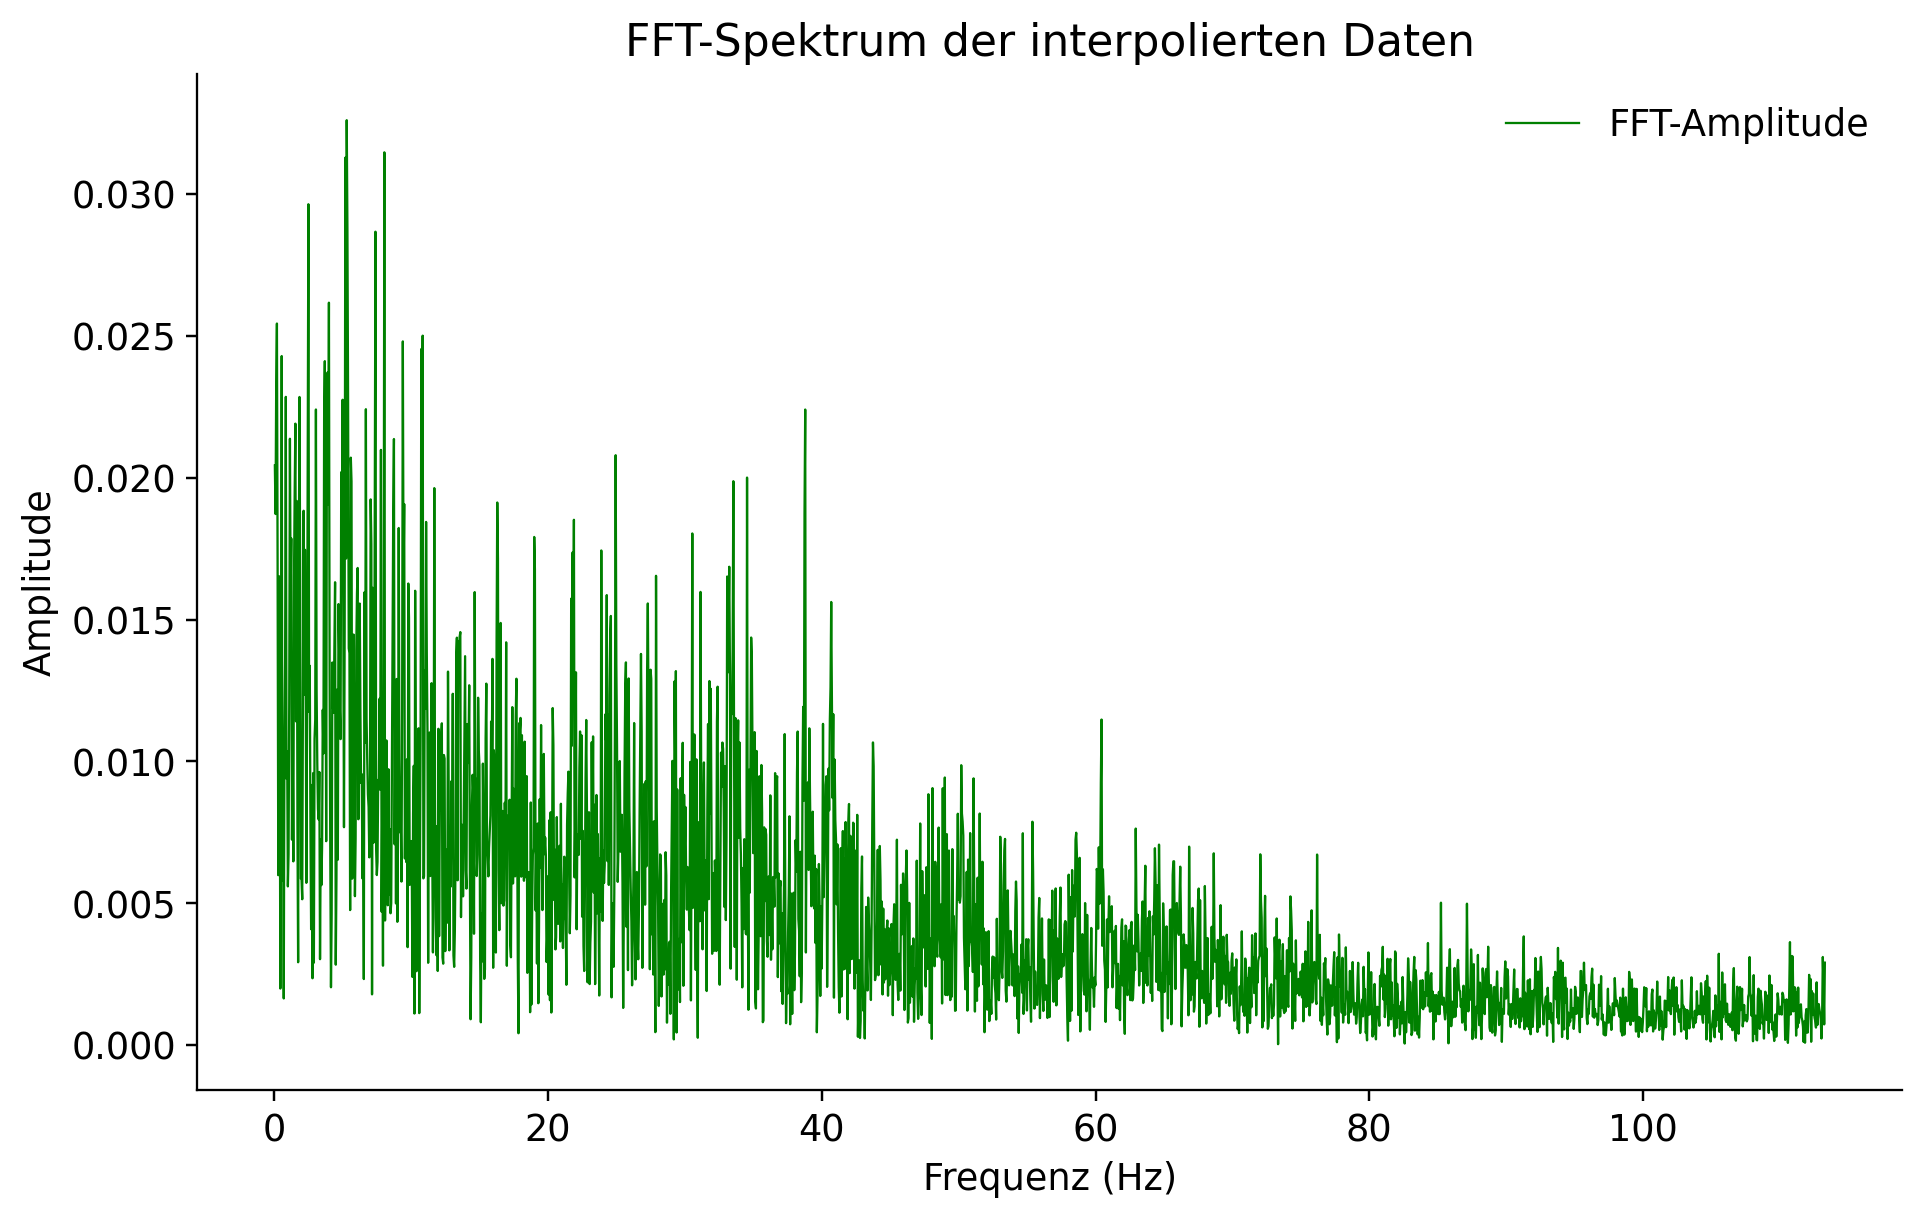

In [28]:
# -------------------------------------------------------------------------------------------#5-start
# TODO: Write my_fft() (in m_postprocessing) and plot results.
fft_amplitude, fft_frequencies = my_fft(interp_data, interp_time)

 

# Plot der Ergebnisse

plt.figure(figsize=(10, 6))

 

# Plot der Amplitude des FFT-Spektrums

plt.plot(fft_frequencies, fft_amplitude, label='FFT-Amplitude', color='green')

#plt.ylim([0,100])

#plt.xlim([0,100])

plt.xlabel('Frequenz (Hz)')

plt.ylabel('Amplitude')

plt.title('FFT-Spektrum der interpolierten Daten')

plt.legend()

#plt.grid(True)

plt.show()

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# Zweiter Versuch
Hier werten Sie den zweiten Gegenstand aus.

##  Versuchsaufbau und -durchführung

Beachten Sie, dass Sie den Code zum Auslesen des Beschleunigungssensor ausschließlich mit dem Raspberry Pi ausführen können.

- Bild von Aufbau des Haushaltsgegenstands:

<img src="Mixer.jpeg" width="500">

- Beschreibung des Aufbaus:
- Vorgangsbeschreibung:

## Versuchsauswertung

Führen Sie die obige Auswertung für den zweiten Gegenstand durch. Sie brauchen dafür nichts neu zu implementieren.

#### 1a. Einlesen der Mess- und Metadaten

In [29]:
path_measurement_folder = "/home/pi/lavalrotor_home_experiment/measurement_data/data_20240109_172816_thomasgruber_Lautsprecher" # replace None by the relative path to the first object's folder
h5_file_name =  "data_20240109_172816_thomasgruber_Lautsprecher.h5" # replace None by the filename of the hdf5-file
file_path= "/home/pi/lavalrotor_home_experiment/measurement_data/data_20240109_172816_thomasgruber_Lautsprecher/data_20240109_172816_thomasgruber_Lautsprecher.h5" 

(setup_json_dict, sensor_settings_dict, probe_name) = evaluate_metadata(
    path_measurement_folder
)

print(json.dumps(setup_json_dict, indent=2, default=str))
print(json.dumps(sensor_settings_dict, indent=2, default=str))
print("Probe: {}".format(probe_name))


{
  "1ee846ef-4df0-632a-bfdb-ef2ea3181b39": {
    "type": "general",
    "name": "general_info",
    "comment": "",
    "path": "/home/pi/lavalrotor_home_experiment/measurement_data/data_20240109_172816_thomasgruber_Lautsprecher/1ee846ef-4df0-632a-bfdb-ef2ea3181b39.json"
  },
  "1ee846f1-b588-6d3c-9659-7c3266d530e8": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "/home/pi/lavalrotor_home_experiment/measurement_data/data_20240109_172816_thomasgruber_Lautsprecher/1ee846f1-b588-6d3c-9659-7c3266d530e8.json"
  },
  "1ee847be-fddd-6ee4-892a-68c4555b0981": {
    "type": "sensor",
    "name": "accelerometer",
    "range": {
      "min": -2,
      "max": 2,
      "units": "standard_gravity"
    },
    "frequency": {
      "value": 800,
      "units": "Hertz"
    },
    "comment": "",
    "path": "/home/pi/lavalrotor_home_experiment/measurement_data/data_20240109_172816_thomasgruber_Lautsprecher/1ee847be-fddd-6ee4-892a-68c4555b0981.json"
  },
  "1eeab0a9-

#### 1b. Auslesen der Beschleunigungen und der Zeit in numpy-arrays

In [35]:
with h5py.File(file_path, "r") as h5_file:
    # Access the datasets under the sensor UUID group
    dataset_x = h5_file[f"RawData/1ee847be-fddd-6ee4-892a-68c4555b0981/acceleration_x"]
    dataset_y = h5_file[f"RawData/1ee847be-fddd-6ee4-892a-68c4555b0981/acceleration_y"]
    dataset_z = h5_file[f"RawData/1ee847be-fddd-6ee4-892a-68c4555b0981/acceleration_z"]
    timestamp_dataset = h5_file[f"RawData/1ee847be-fddd-6ee4-892a-68c4555b0981/timestamp"]


    
    time = np.array(timestamp_dataset)
    acceleration_x = np.array(dataset_x)
    acceleration_y = np.array(dataset_y)
    acceleration_z = np.array(dataset_z)
    
    print(acceleration_x)
    print(acceleration_y)
    print(acceleration_z)
    print(time)


[-6.276256  -6.276256  -6.276256  ... -4.2756994  0.0784532  0.0784532]
[ 1.96133    1.96133    1.96133   ... -0.3530394  2.6674088  2.6674088]
[-3.334261  -3.334261  -3.334261  ... -6.9431082 -6.9431082 -6.9431082]
[1.70481770e+09 1.70481770e+09 1.70481770e+09 ... 1.70481772e+09
 1.70481772e+09 1.70481772e+09]


#### 2. Betrag der Beschleunigung berechnen


In [31]:
 absolute_value_acceleration= get_vec_accel(acceleration_x, acceleration_y, acceleration_z)

print(absolute_value_acceleration)




[7.37261834 7.37261834 7.37261834 ... 8.16167836 7.43827776 7.43827776]


#### 3. Darstellung der Messdaten

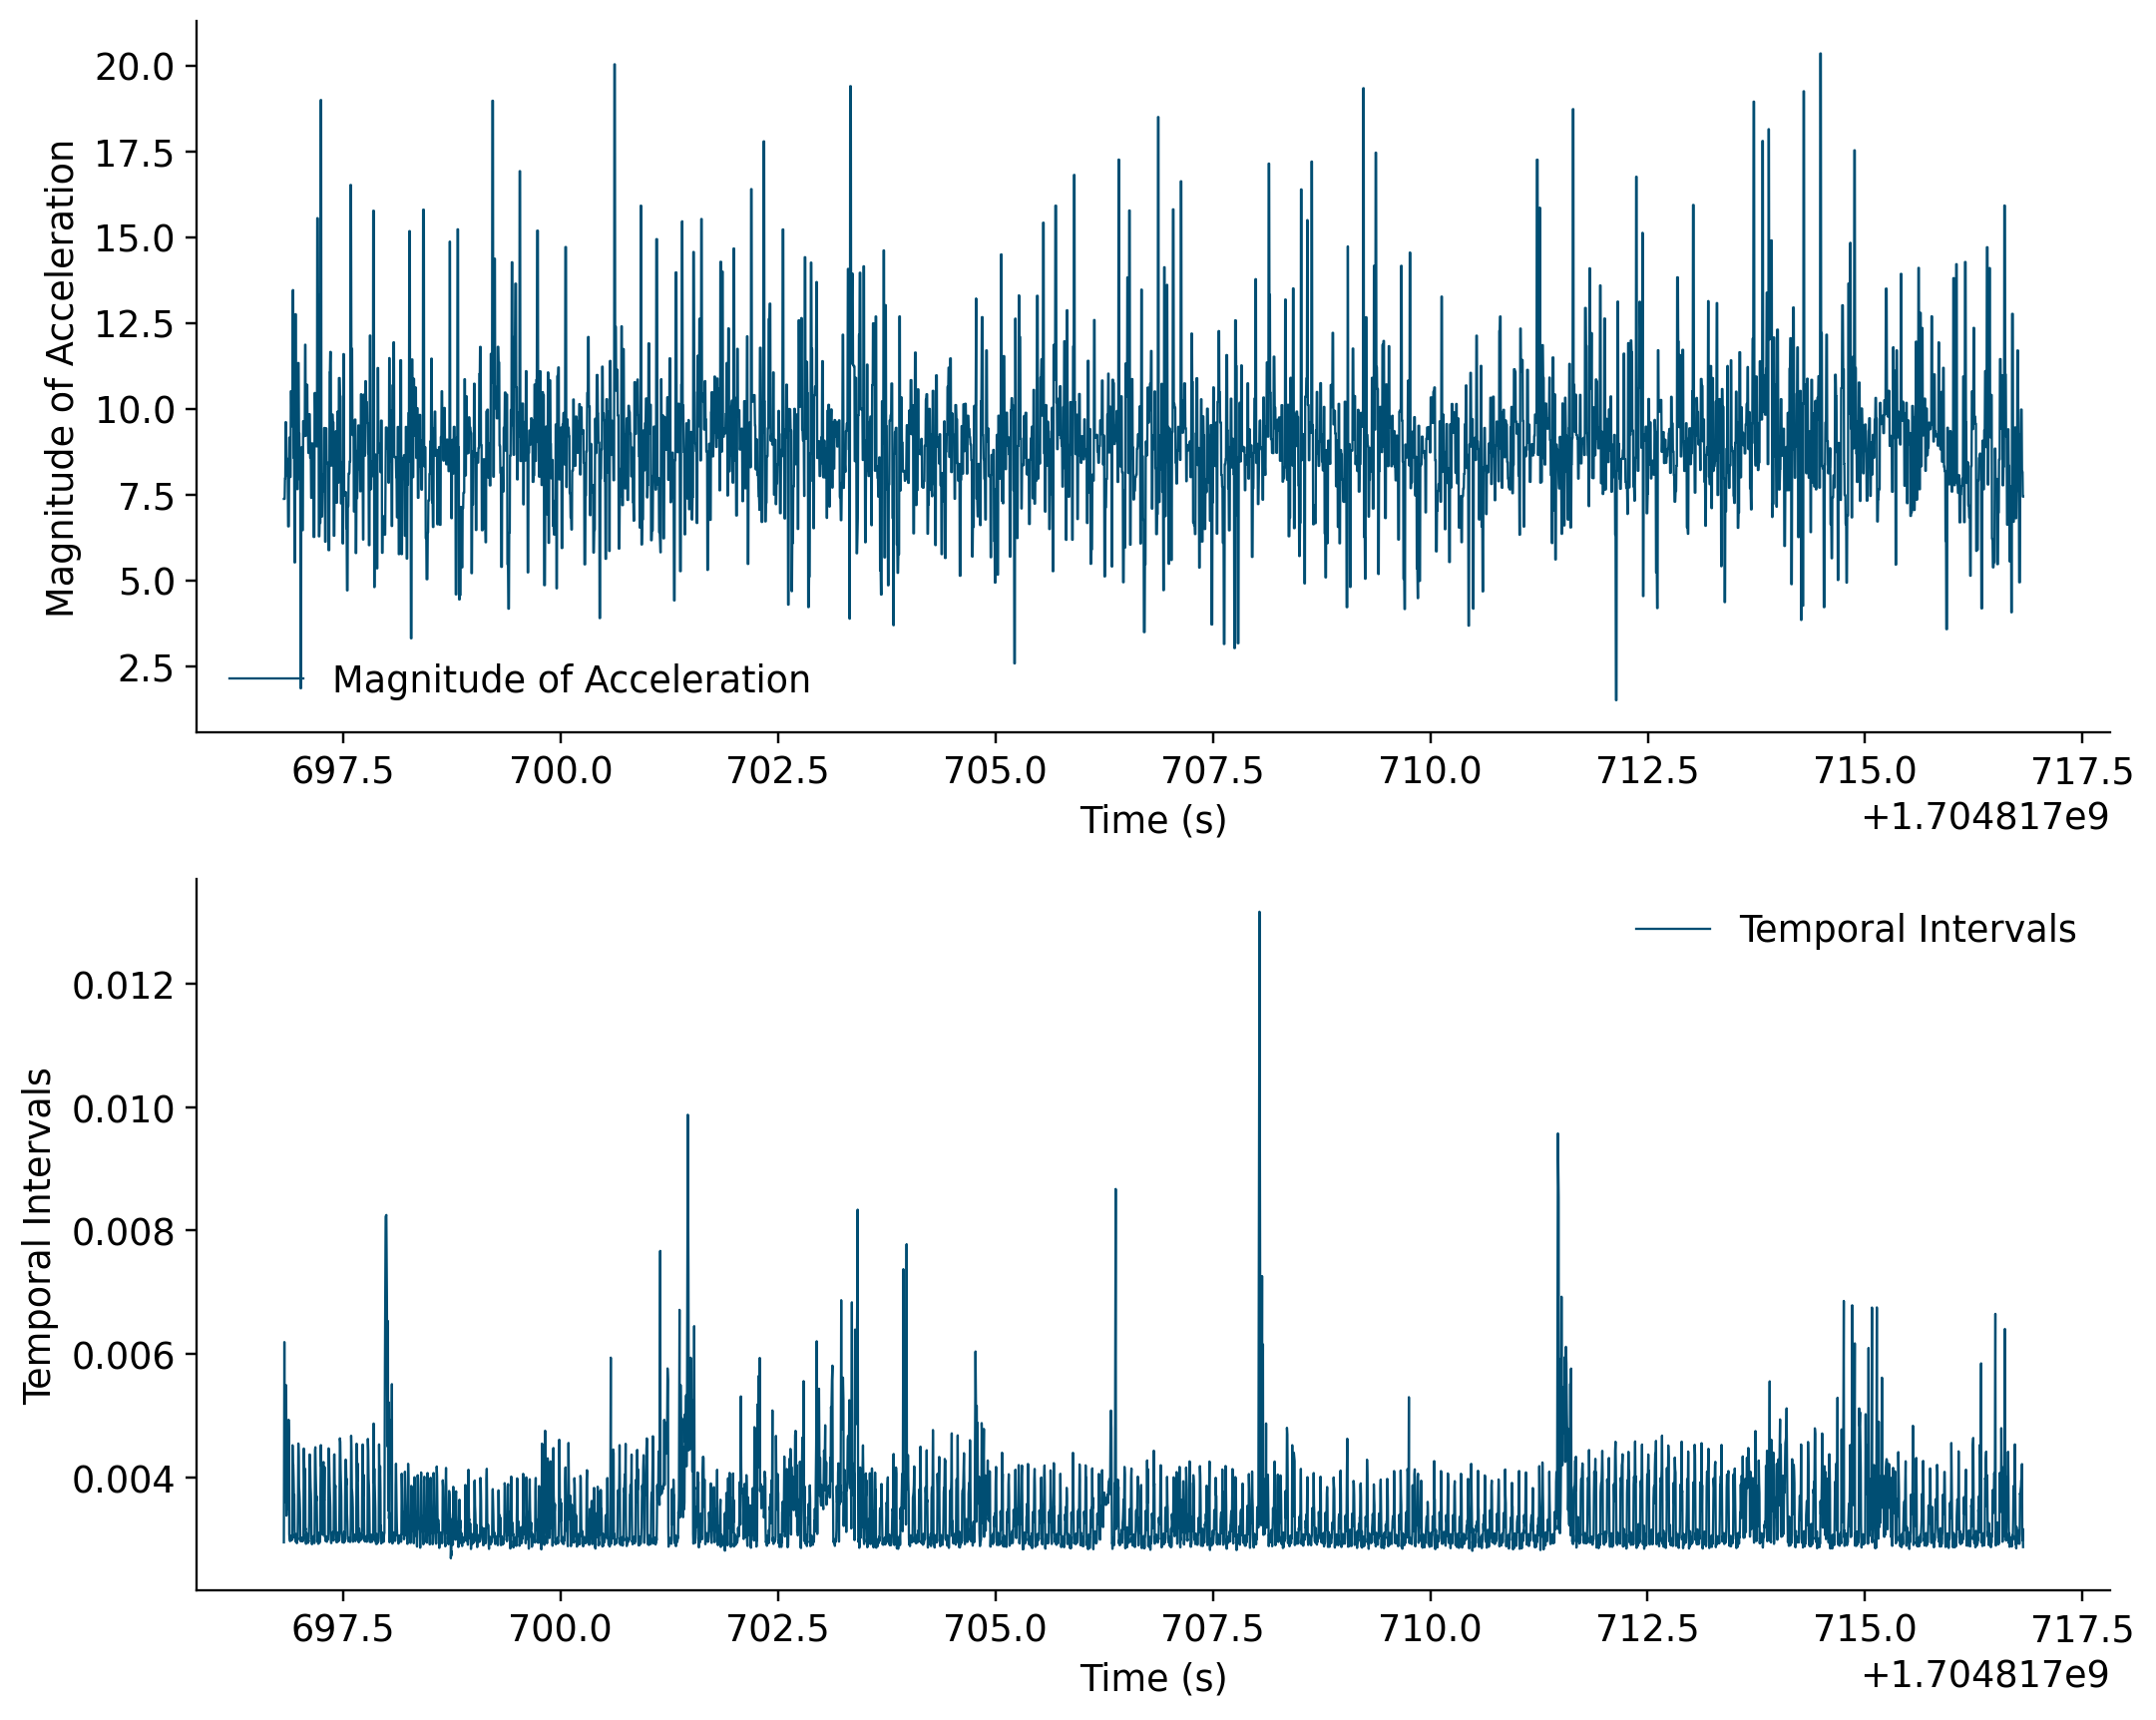

In [32]:
zeitintervall = np.diff(time)

# Plotte die Ergebnisse
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plotte die Betragsgröße der Beschleunigung über die Zeit
ax1.plot(time, absolute_value_acceleration, label='Magnitude of Acceleration')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Magnitude of Acceleration')
ax1.legend()

# Plotte zeitliche Intervalle über die Zeit
ax2.plot(time[1:], zeitintervall, label='Temporal Intervals')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Temporal Intervals')
ax2.legend()
plt.tight_layout()
plt.show()


#### 4. Interpolation der Messwerte



In [33]:
# TODO: Write the function interpolation() (in m_postprocessing) to linearly interpolate the

# acceleration.

#with h5py.File(file_path, "r") as h5_file:
    #timestamp_dataset = h5_file[f"RawData/1ee847be-fddd-6ee4-892a-68c4555b0981/timestamp"]
    #time = np.array(timestamp_dataset)
    #print(time)

   

interp_time, interp_data = interpolation(time, absolute_value_acceleration)

 

# Drucken Sie die Ergebnisse oder visualisieren Sie sie

print("Interpolierte Zeit:", interp_time)

print("Interpolierte Daten:", interp_data)



Interpolierte Zeit: [1.70481770e+09 1.70481770e+09 1.70481770e+09 ... 1.70481772e+09
 1.70481772e+09 1.70481772e+09]
Interpolierte Daten: [7.37261834 7.37261834 7.37261834 ... 8.16167836 7.54292027 7.43827776]


#### 5 & 6. FFT durchführen und graphisch darstellen


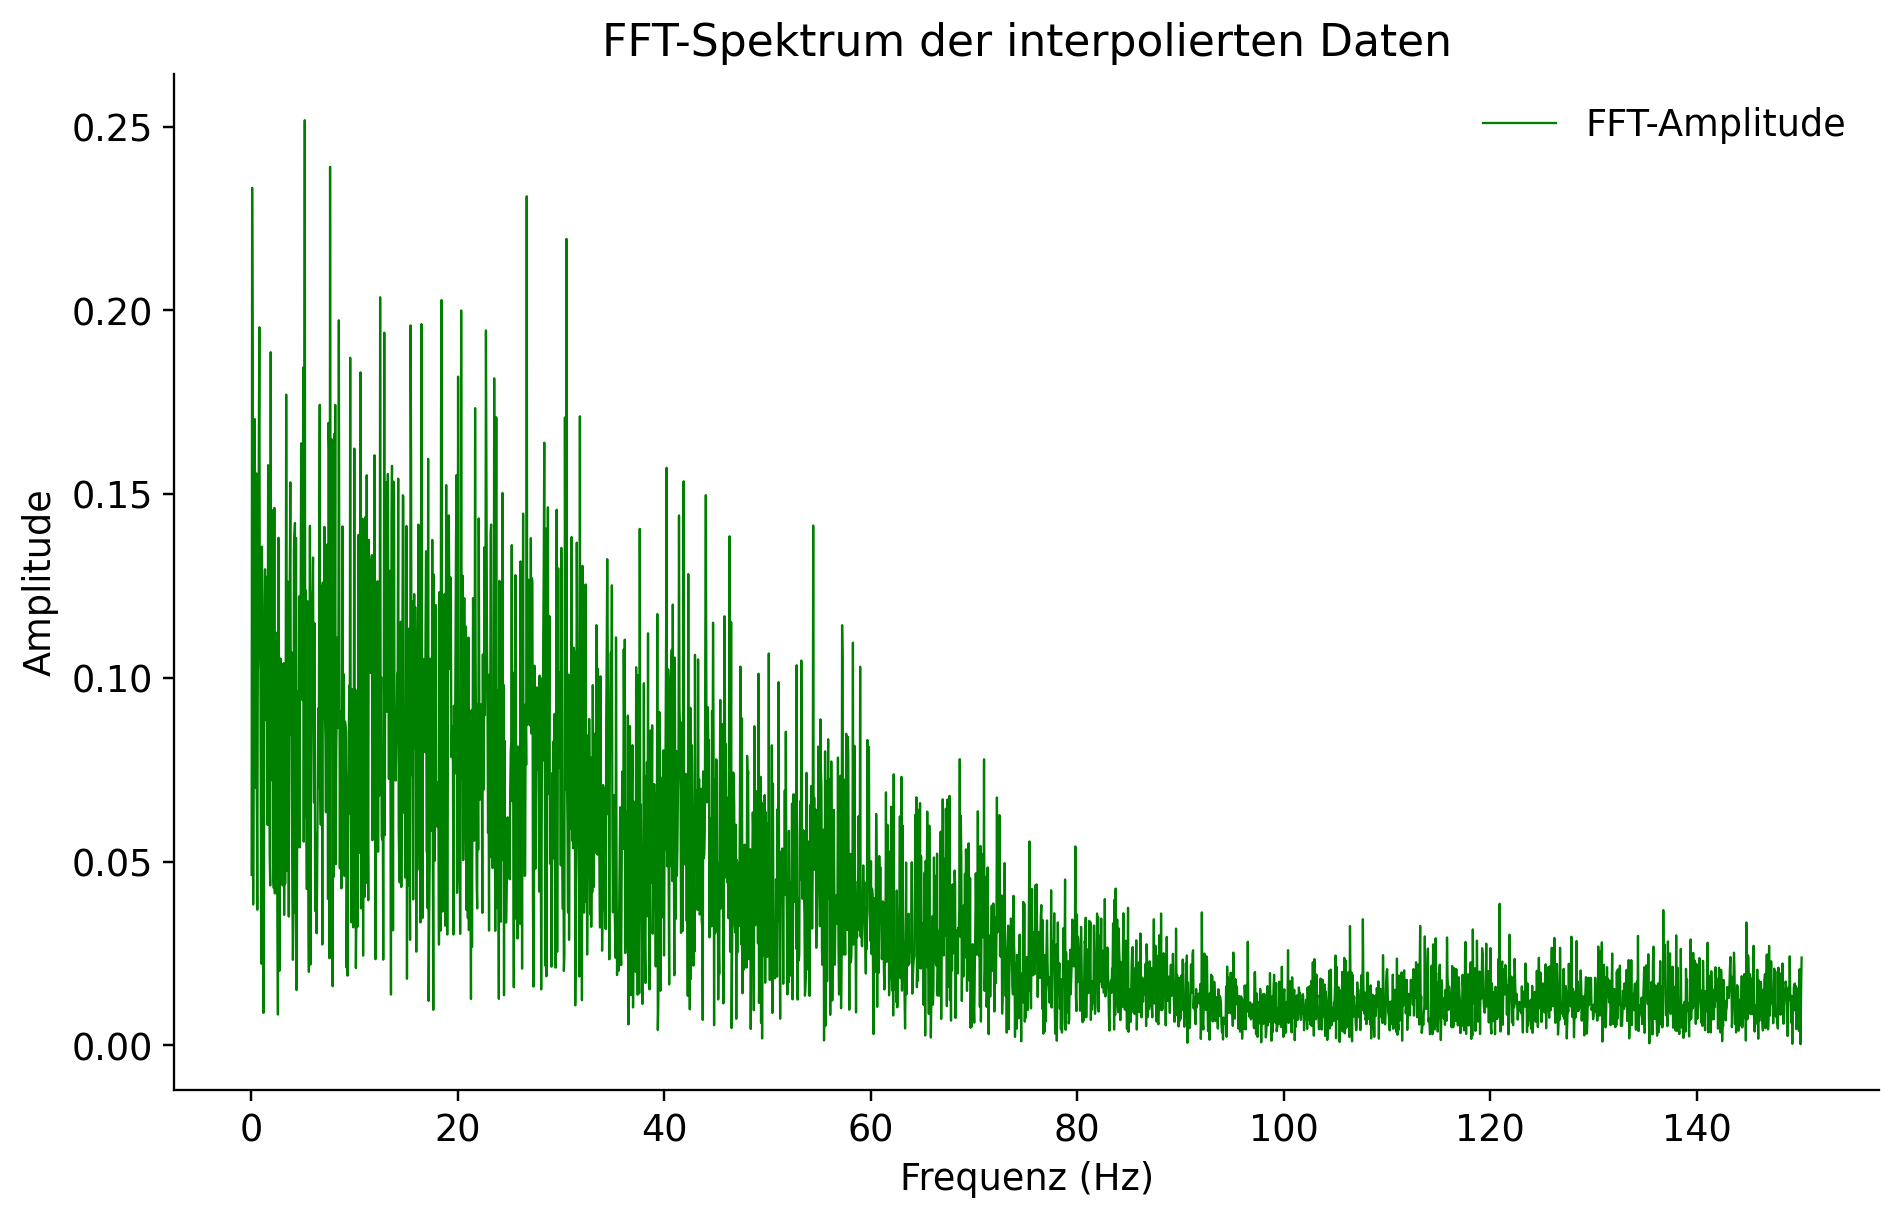

In [34]:
fft_amplitude, fft_frequencies = my_fft(interp_data, interp_time)

 

# Plot der Ergebnisse

plt.figure(figsize=(10, 6))

 

# Plot der Amplitude des FFT-Spektrums

plt.plot(fft_frequencies, fft_amplitude, label='FFT-Amplitude', color='green')

#plt.ylim([0,100])

#plt.xlim([0,100])

plt.xlabel('Frequenz (Hz)')

plt.ylabel('Amplitude')

plt.title('FFT-Spektrum der interpolierten Daten')

plt.legend()

#plt.grid(True)

plt.show()

## Diskussion
Es ist durchaus möglich mit solch einfachen Mitteln ein sinnvolles Ergebnis zu erzielen, wie man an den Diagrammen erkennen kann. 

## Fazit
Ziehen Sie ein Fazit zum durchgeführten Versuch, gehen Sie dabei gerne auf Ihrer persönliche Meinung oder Ihre Lernziele ein.

An sich interessant, leider hatte ich öfters Probleme mit der Hardware und Jupiter Lab. Ich musste den Namen von Dateien manuell ändern.